## GPU Usage in Online Deep Learning

GPUs: 
* allow high degree of parallelization &rarr; yield significant speed-up over CPUs 
* are main contributors to the success of (batch) deep learning 

How useful are GPUs in online deep learning? 

In [3]:
# Imports and util functions
import pandas as pd
import torch
from itertools import product
from torch import nn
from time import time
from tqdm import tqdm
from deep_river.classification import Classifier
from river import compose, preprocessing, datasets, metrics
import matplotlib.pyplot as plt

from utils import seed_everything


class StreamBuffer:
    def __init__(self, size=8) -> None:
        self.xs = []
        self.ys = []
        self.size = size
        self.current_size = 0
        self.is_full = False

    def append(self, x: dict, y: int = None):
        self.xs.append(list(x.values()))
        self.ys.append(y)
        if len(self.ys) == self.size:
            self.is_full = True

    def get(self):
        self.is_full = False
        result = pd.DataFrame.from_records(self.xs), pd.Series(self.ys)
        self.xs.clear()
        self.ys.clear()
        return result


# Load dataset define PyTorch module etc.
n_samples = 10_000
data = list(datasets.Insects(variant="abrupt_balanced").take(n_samples))

seed_everything(42)

# Define PyTorch module
class MyMLP(nn.Module):
    def __init__(self, n_features, hidden_units=64, hidden_layers=2):
        super().__init__()
        self.linear1 = nn.Linear(n_features, hidden_units)
        self.hiddens = nn.ModuleList(
            [nn.Linear(hidden_units, hidden_units)] * (hidden_layers - 1)
        )
        self.linear3 = nn.Linear(hidden_units, 6)

    def forward(self, X, **kwargs):
        z = torch.relu(self.linear1(X))
        for layer in self.hiddens:
            z = torch.relu(layer(z))
        return torch.softmax(self.linear3(z), dim=-1)

In [4]:
# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU:", torch.cuda.get_device_name(0))
    # Set device to use to GPU with index 0
    dev = "cuda:0"
else:
    print("CUDA is not available.")
    dev = "cpu"

CUDA is available.
GPU: NVIDIA GeForce RTX 3090


In [5]:
# Create classification model
model = Classifier(module=MyMLP, lr=0.5, device=dev)

metric = metrics.Accuracy()

start = time()
# Run anomaly detection model using GPU (if available)
for x, y in tqdm(data):
    # Predict and train on current instance
    pred = model.predict_one(x)
    model.learn_one(x, y)
    # Record results
    metric.update(y, pred)

print("\nGPU Runtime: {:.2f} Seconds".format(time() - start))

100%|██████████| 10000/10000 [00:11<00:00, 893.68it/s]


GPU Runtime: 11.20 Seconds


In [6]:
# Create anomaly detection pipeline
model = Classifier(module=MyMLP, lr=0.5, device="cpu")

metric = metrics.Accuracy()

start = time()
# Run anomaly detection pipeline using GPU (if available)
for x, y in tqdm(data):
    # Predict and train on current instance
    pred = model.predict_one(x)
    model.learn_one(x, y)
    # Record results
    metric.update(y, pred)

print("\nCPU Runtime: {:.2f} Seconds".format(time() - start))

100%|██████████| 10000/10000 [00:04<00:00, 2105.41it/s]


CPU Runtime: 4.75 Seconds


* The pipeline runs significantly faster on the CPU! 
* Why? 
    + Small Network
    + Batch Size = 1 
* &rarr; Very little parallelism
* What happens if we increase the batch size by buffering training instances? 

In [7]:
# Implement function to train
def run_batch_wise(batch_size, device, verbose=True):
    # Add a buffer storing samples until desired batch size is reached
    buffer = StreamBuffer(size=batch_size)
    model = Classifier(
        module=MyMLP, lr=0.5, device=device
    )  # TODO: Remove this for "hands-on" blank text?
    metric = metrics.Accuracy()

    start = time()
    iterator = tqdm(data) if verbose else data
    for x, y in iterator:
        pred = model.predict_one(
            x
        )  # TODO: Remove this for "hands-on" blank text?
        metric.update(y, pred)

        # Store samples in buffer
        buffer.append(x, y)

        # Perform updates once buffer is full
        if buffer.is_full:
            x_batch, y_batch = buffer.get()
            model.learn_many(
                x_batch, y_batch
            )  # TODO: Remove this for "hands-on" blank text?

    return metric.get(), time() - start


accuracy, runtime = run_batch_wise(batch_size=8, device="cpu")
print("CPU Runtime: {:.2f} Seconds \n".format(runtime))
accuracy, runtime = run_batch_wise(batch_size=8, device=dev)
print("\nGPU Runtime: {:.2f} Seconds".format(runtime))

100%|██████████| 10000/10000 [00:01<00:00, 5171.30it/s]


CPU Runtime: 1.94 Seconds 



100%|██████████| 10000/10000 [00:03<00:00, 2802.97it/s]


GPU Runtime: 3.57 Seconds


* The GPU still yields no increase in execution speed. 
* How large does the batch size have to get for the GPU to be preferable? 

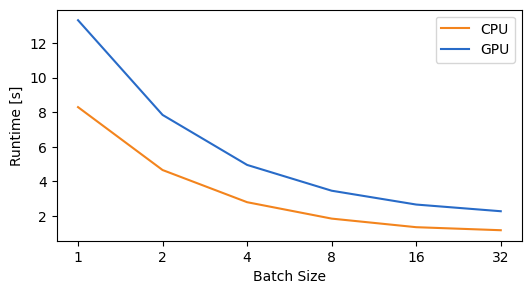

In [8]:
batch_sizes = [2**i for i in range(6)]
results = []
for dev in ["cpu", "cuda:0"]:
    dname = "GPU" if dev == "cuda:0" else "CPU"
    for batch_size in batch_sizes:
        accuracy, runtime = run_batch_wise(batch_size, dev, verbose=False)
        results.append(
            {
                "runtime": runtime,
                "accuracy": accuracy,
                "device": dname,
                "batch_size": batch_size,
            }
        )


df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(6, 3))
colors = {"CPU": "#F3841D", "GPU": "#286BC8"}
for dev, dfd in df.groupby("device"):
    ax.plot(dfd["batch_size"], dfd["runtime"], label=dev, c=colors[dev])
ax.set_xlabel("Batch Size")
ax.set_ylabel("Runtime [s]")
net_widths = df["batch_size"].unique()
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l = ax.legend()

* GPU training is bottlenecked by data transfer between System and GPU memory
* CPU remains faster even at relatively large batch sizes
* What about larger neural nets?
* How large must the network be to run faster on the GPU?

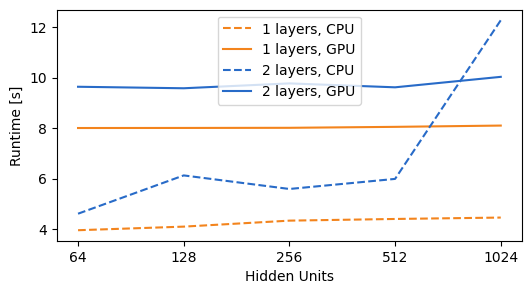

In [9]:
# Test runtime for increasingly wider MLPs with one or two hidden layers:
results = []
configs = product([1, 2], [2**i for i in range(6, 11)], ["cpu", "cuda:0"])
for net_depth, net_width, dev in list(configs):
    dname = "GPU" if dev == "cuda:0" else "CPU"
    model = Classifier(
        module=MyMLP,
        lr=0.5,
        device=dev,
        hidden_units=net_width,
        hidden_layers=net_depth,
    )
    metric = metrics.Accuracy()

    start = time()

    # Run network using GPU (if available)
    for x, y in data:
        # Predict and train on current instance
        pred = model.predict_one(x)
        model.learn_one(x, y)
        # Record results
        metric.update(y, pred)
    results.append(
        {
            "runtime": time() - start,
            "accuracy": metric.get(),
            "device": dname,
            "hidden_units": net_width,
            "hidden_layers": net_depth,
        }
    )

df = pd.DataFrame(results)
df = df.sort_values(by="hidden_units")
fig, ax = plt.subplots(figsize=(6, 3))
colors = {1: "#F3841D", 2: "#286BC8"}
styles = {"CPU": "dashed", "GPU": "solid"}
for (hidden_layers, dev), dfd in df.groupby(["hidden_layers", "device"]):
    ax.plot(
        dfd["hidden_units"],
        dfd["runtime"],
        label=f"{hidden_layers} layers, {dev}",
        c=colors[hidden_layers],
        linestyle=styles[dev],
    )
ax.set_xlabel("Hidden Units")
ax.set_ylabel("Runtime [s]")
net_widths = df["hidden_units"].unique()
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l = ax.legend()

* Difficult to reach parameter count where GPU is faster with only one hidden layer
* GPU yields better runtime for wide network with two hidden layers
* In batch learning: larger model &rarr; better performance &rarr; GPUs are mandatory
* Is the same true in online deep learning?

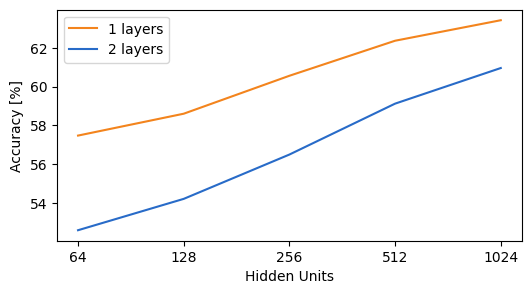

In [10]:
dfc = df[(df["device"] == "CPU")]
fig, ax = plt.subplots(figsize=(6, 3))
for hidden_layers, dfl in dfc.groupby("hidden_layers"):
    ax.plot(
        dfl["hidden_units"],
        dfl["accuracy"] * 100,
        label=f"{hidden_layers} layers",
        color=colors[hidden_layers],
    )
ax.set_xlabel("Hidden Units")
ax.set_ylabel("Accuracy [%]")
net_widths = dfl["hidden_units"]
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l= ax.legend()

* Average accuracy increases with network width 
* Deeper model performs significantly worse than shallower model
* Explanation: additional ReLU layer increases gradient sparsity slowing convergence 